### [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
- Linear classification model
- aka *logit regression*, *max-entropy (MaxEnt)* classification, and *log-linear* classification.
- Possible outcome probabilities are modeled with a [logistic function](https://en.wikipedia.org/wiki/Logistic_function)
- Solver options:
    - **"liblinear"**: uses coordinate descent based on [LIBLINEAR](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) C++ library.
    - **"newton-cg"**: robust to unscaled datasets.
    - **"lbfgs"**: uses the Broyden-Fletcher-Goldfarb-Shanno algorithm (a quasi-Newton solver). Use on smaller datasets. Default choice.
    - **"sag"**: uses Stochastic Average Gradient descent. Faster on larger datasets.
    - **"saga"**: variant of "sag"; preferred choice for larger, *sparse multinomial* LR problems.
    
### [Logistic Regression (Cross Validated)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)
- LR with built-in cross-validation support to find optimal `C` and `l1_ratio` params.

### Example: comparison of sparsity (% of zero coefficients) vs L1, L2 & ElasticNet penalties in Logistic Regression
- Using 8x8 digits images, classified into two groups (0-4, 5-9)
- Observe: larger C = more model freedom; smaller C = more model constraint

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model  import LogisticRegression as LR
from sklearn               import datasets
from sklearn.preprocessing import StandardScaler as SS

In [2]:
X, y     = datasets.load_digits(return_X_y=True)
X        = SS().fit_transform(X)
y        = (y > 4).astype(int) # classify smaller vs larger digits
l1_ratio = 0.5  # L1 weight in Elastic-Net regularization

C=1.00
Sparsity with L1 penalty:                6.25%
Sparsity with Elastic-Net penalty:       4.69%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.90
Score with Elastic-Net penalty:          0.90
Score with L2 penalty:                   0.90
C=0.10
Sparsity with L1 penalty:                28.12%
Sparsity with Elastic-Net penalty:       12.50%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.90
Score with Elastic-Net penalty:          0.90
Score with L2 penalty:                   0.90
C=0.01
Sparsity with L1 penalty:                84.38%
Sparsity with Elastic-Net penalty:       68.75%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.86
Score with Elastic-Net penalty:          0.88
Score with L2 penalty:                   0.89


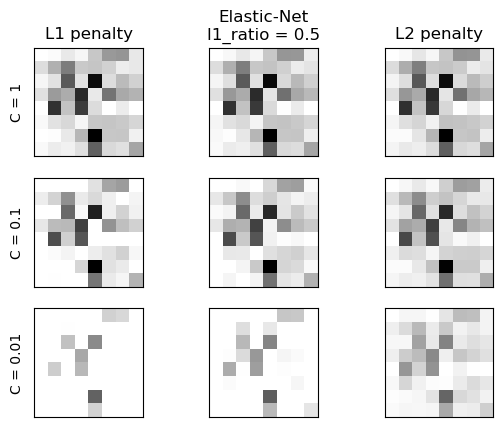

In [3]:
fig, axes = plt.subplots(3, 3)

# Set regularization
for i, (C, axes_row) in enumerate(zip((1, 0.1, 0.01), axes)):
    # turn down tolerance for short training time
    clf_l1_LR = LR(C=C, penalty='l1',         tol=0.01, solver='saga')
    clf_l2_LR = LR(C=C, penalty='l2',         tol=0.01, solver='saga')
    clf_en_LR = LR(C=C, penalty='elasticnet', tol=0.01, solver='saga', l1_ratio=l1_ratio)
    clf_l1_LR.fit(X, y)
    clf_l2_LR.fit(X, y)
    clf_en_LR.fit(X, y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    coef_en_LR = clf_en_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.2f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:",
                                  sparsity_en_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:",
                                 clf_l1_LR.score(X, y)))
    print("{:<40} {:.2f}".format("Score with Elastic-Net penalty:",
                                 clf_en_LR.score(X, y)))
    print("{:<40} {:.2f}".format("Score with L2 penalty:",
                                 clf_l2_LR.score(X, y)))

    if i == 0:
        axes_row[0].set_title("L1 penalty")
        axes_row[1].set_title("Elastic-Net\nl1_ratio = %s" % l1_ratio)
        axes_row[2].set_title("L2 penalty")

    for ax, coefs in zip(axes_row, [coef_l1_LR, coef_en_LR, coef_l2_LR]):
        ax.imshow(np.abs(coefs.reshape(8, 8)), interpolation='nearest',
                  cmap='binary', vmax=1, vmin=0)
        ax.set_xticks(())
        ax.set_yticks(())

    axes_row[0].set_ylabel('C = %s' % C)

plt.show()

### Example: Regularization path (coefficients vs log(C), Logistic Regression)

In [4]:
iris = datasets.load_iris()
X,y  = iris.data, iris.target
X    = X[y != 2]
y    = y[y != 2]
X   /= X.max()  # Normalize X to speed-up convergence

In [5]:
from sklearn.svm import l1_min_c
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)

from time import time
start = time()

clf = LR(penalty='l1', 
         solver='liblinear',
         tol=1e-6, 
         max_iter=int(1e6),
         warm_start=True,
         intercept_scaling=10000.)

coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())

print("This took %0.3fs" % (time() - start))

This took 0.044s


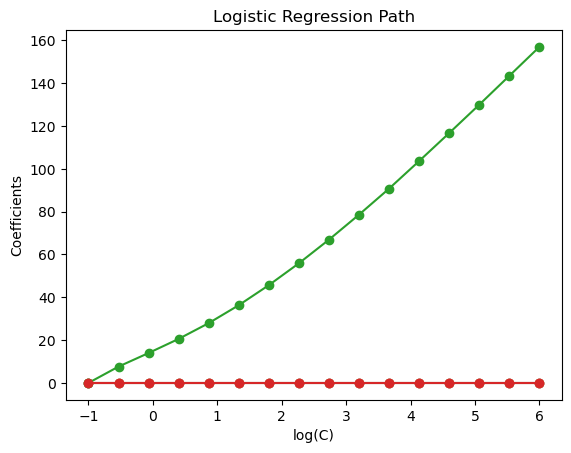

In [6]:
coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()

plt.xlabel('log(C)'); plt.ylabel('Coefficients'); plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

### Example: Multinomial vs One-vs-Rest (OVR) Logistic Regression
- using artificial 3-class dataset

In [7]:
from sklearn.datasets import make_blobs

centers        = [[-5, 0], [0, 1.5], [5, -1]]
X, y           = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X              = np.dot(X, transformation)

training score : 0.995 (multinomial)
training score : 0.976 (ovr)


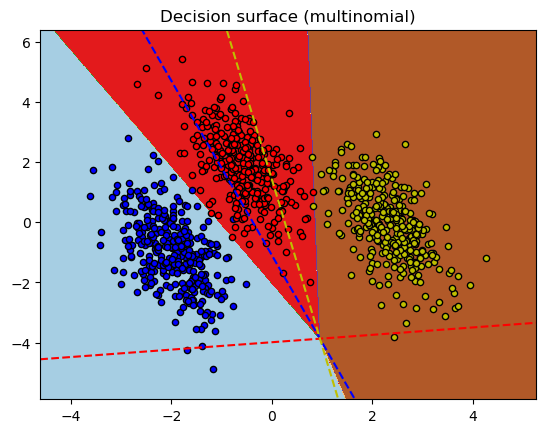

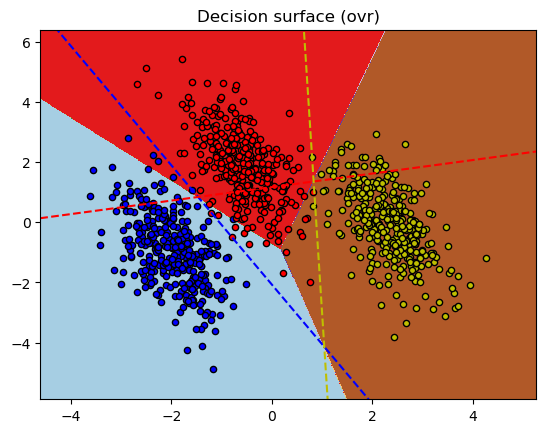

In [8]:
for multi_class in ('multinomial', 'ovr'):
    clf = LR(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot decision boundary. Assign a color to each point in the mesh 
    # [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

### Example: Multiclass (multinomial vs one-vs-rest) document classification using logistic regression
- Using the 20newsgroups dataset
- Expectation: multinomial LR should be faster & more accurate
- Use L1 sparsity to trim non-useful weights to zero, if goal is to find strongest discriminative vocabulary of each class.
- Use L2 (non-sparsity-inducing) penalty instead for best predictive accuracy.

In [9]:
import warnings, timeit
from sklearn.datasets        import fetch_20newsgroups_vectorized as Fetch20
from sklearn.linear_model    import LogisticRegression as LR
from sklearn.model_selection import train_test_split   as TTS
from sklearn.exceptions      import ConvergenceWarning as CW

In [10]:
warnings.filterwarnings("ignore", category=CW,module="sklearn")
t0        = timeit.default_timer()
solver    = 'saga'
n_samples = 10000

In [11]:
X, y = Fetch20(subset='all', return_X_y=True)
X    = X[:n_samples]
y    = y[:n_samples]

X_train, X_test, y_train, y_test = TTS(X, y, random_state=42, stratify=y, test_size=0.1)
train_samples, n_features        = X_train.shape
n_classes                        = np.unique(y).shape[0]

In [12]:
models = {'ovr':         {'name': 'One versus Rest', 'iters': [1, 2, 4]},
          'multinomial': {'name': 'Multinomial',     'iters': [1, 3, 7]}}

[model=One versus Rest, solver=saga] Number of epochs: 1
[model=One versus Rest, solver=saga] Number of epochs: 2
[model=One versus Rest, solver=saga] Number of epochs: 4
Test accuracy for ovr: 0.7510
% non-zero coeffs for ovr, per class:
 [0.34740637 0.37200151 0.42042319 0.46346469 0.24672001 0.42272898
 0.29898468 0.27746393 0.58951478 0.34663777 0.4173488  0.29360449
 0.42349758 0.40658842 0.60411815 0.31819964 0.31589384 0.28207552
 0.36124113 0.26747216]
Run time (4 epochs) for ovr:1.94
[model=Multinomial, solver=saga] Number of epochs: 1
[model=Multinomial, solver=saga] Number of epochs: 3
[model=Multinomial, solver=saga] Number of epochs: 7
Test accuracy for multinomial: 0.7450
% non-zero coeffs for multinomial, per class:
 [0.12912449 0.11528972 0.13066169 0.13450468 0.11990131 0.15756262
 0.13527328 0.09223178 0.07685982 0.12066991 0.14065346 0.10606655
 0.17985197 0.12066991 0.17908337 0.21597608 0.10990954 0.07762841
 0.07301682 0.14295926]
Run time (7 epochs) for multinomi

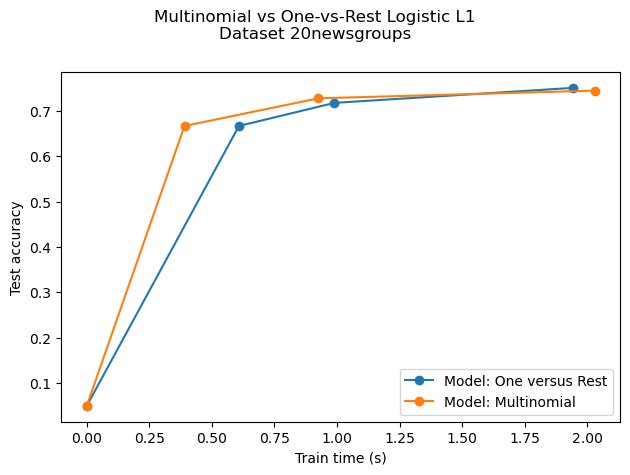

In [13]:
for model in models:
    accuracies   = [1 / n_classes]
    times        = [0]
    densities    = [1]
    model_params = models[model]

    # Small #epochs = faster runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LR(solver=solver,
                multi_class=model,
                penalty='l1',
                max_iter=this_max_iter,
                random_state=42)
        
        t1 = timeit.default_timer()
        lr.fit(X_train, y_train)
        train_time = timeit.default_timer() - t1

        y_pred     = lr.predict(X_test)
        accuracy   = np.sum(y_pred == y_test) / y_test.shape[0]
        density    = np.mean(lr.coef_ != 0, axis=1) * 100
        
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)

    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies

    print('Test accuracy for %s: %.4f' % (model, accuracies[-1]))
    print('%% non-zero coeffs for %s, '
    'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = timeit.default_timer() - t0
print('Example run in %.3f s' % run_time)
plt.show()

### Example: Multinomial LR with l1 penalty on MNIST
- Using saga solver (#samples >> #features)

In [14]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import StandardScaler as SS
from sklearn.utils import check_random_state as CRS

In [15]:
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Turn seed into a np.random.RandomState instance
random_state = CRS(0); permutation  = random_state.permutation(X.shape[0])
print('permutation: ', permutation)

X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = TTS(
    X, y, train_size=train_samples, test_size=10000)

scaler = SS()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


permutation:  [10840 56267 14849 ... 42613 43567 68268]


Sparsity with L1 penalty:   78.81%
Test score with L1 penalty: 0.8326


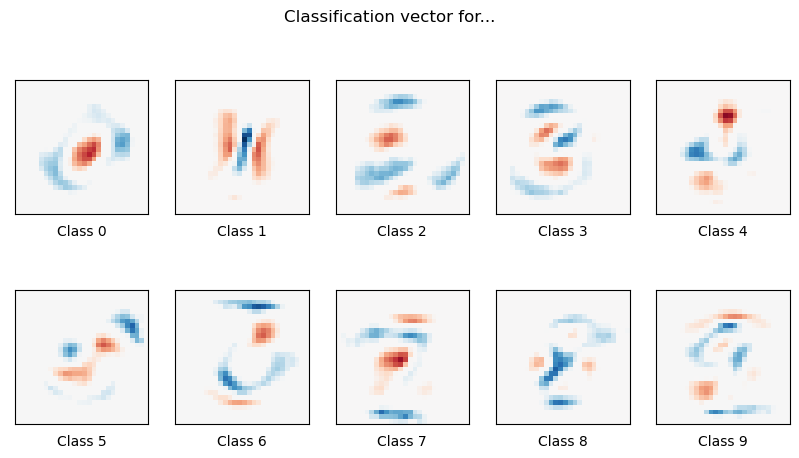

In [17]:
# Turn up tolerance for faster convergence
clf = LR(C      =50.0/train_samples, 
         penalty='l1', 
         solver ='saga', 
         tol=0.1)
clf.fit(X_train, y_train)

sparsity = np.mean(clf.coef_ == 0) * 100
score    = clf.score(X_test, y_test)

print("Sparsity with L1 penalty:   %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f"   % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()

for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')
plt.show()